<a href="https://colab.research.google.com/github/Prajwal01406/Risk-Simulation-using-Heston-Model/blob/main/Portfolio_Heston_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [291]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

In [292]:
#Start and End date
start_date = '2020-08-21'
end_date = '2025-08-21'

In [293]:
#Ticker symbols for the portfolio stocks
tickers = ['RELIANCE.BO','HDFCBANK.BO', 'TRENT.BO', 'HCLTECH.BO']

#weightage of each stock
weights = np.array([0.25,0.25,0.25,0.25,])

In [294]:
# Downloading the past Close prices
data = pd.DataFrame()
for t in tickers:
  close = yf.download(t , start = start_date, end = end_date)
  data[t] = close['Close']
data

/tmp/ipython-input-4155351778.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  close = yf.download(t , start = start_date, end = end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-4155351778.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  close = yf.download(t , start = start_date, end = end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-4155351778.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  close = yf.download(t , start = start_date, end = end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-4155351778.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  close = yf.download(t , start = start_date, end = end_date)
[*********************100%***********************]  1 of 1 completed


,RELIANCE.BO,HDFCBANK.BO,TRENT.BO,HCLTECH.BO
Date,,,,
2020-08-21,1009.812134,1028.360474,603.385742,584.111023
2020-08-24,1016.748779,1057.817993,620.295654,583.697449
2020-08-25,1009.933472,1060.706787,642.576965,581.175293
2020-08-26,1036.540039,1058.670288,646.207642,589.320679
2020-08-27,1024.340210,1053.224121,645.262695,587.170715
...,...,...,...,...
2025-08-13,1377.150024,1979.349976,5398.600098,1500.400024
2025-08-14,1373.750000,1991.400024,5369.149902,1488.900024
2025-08-18,1380.949951,2003.650024,5520.500000,1487.250000


<Axes: xlabel='Date'>

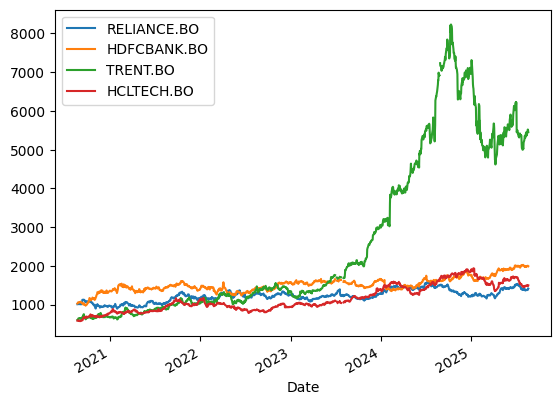

In [295]:
data.plot()

#Required Parameters

v[t] = *Instantaneous Variance*

 μ = *Mean Returns*

 θ = *long run variance*

 ξ = *Vol of Vol*

 κ = *Velocity of reversion*

 ρ = *Correlation between price and variance*

In [296]:
# Defining dt
days = 252
dt = 1/days

In [297]:
#Calculating mu or the mean returns
returns = data.pct_change()
portfolio_returns = returns.dot(weights)

cum_returns = ( 1 + portfolio_returns).prod() - 1
N = portfolio_returns.shape[0]
mu = ( 1 + cum_returns )** (252/N) - 1

print(f"mu: {mu}")

mu: 0.2610854149309161


/tmp/ipython-input-1518177456.py:2: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = data.pct_change()


In [298]:
# Calculating the Intantaneous Variance ( v[t] )
daily_var = portfolio_returns.rolling(window= 30).var().dropna() * 252

# calculating Theta
theta = daily_var.mean()

print(f"Theta: {theta}")

Theta: 0.03160917639441866


In [299]:
from sklearn.linear_model import LinearRegression

In [300]:
# Regressing the Value of Kappa

v_t = daily_var[: -1].values
v_next = daily_var[1:].values

X = (theta - v_t).reshape(-1,1)
y = (v_next - v_t)

reg = LinearRegression().fit(X,y)

kappa = reg.coef_[0] / (dt)
print(f"kappa: {kappa.round(2)}")

kappa: 3.48


In [301]:
# Calculating the value of Xi

residuals = y - (theta - v_t) * reg.coef_
Xi = residuals.std() / np.sqrt(dt)

print( f" Xi: {Xi}")

 Xi: 0.04820346566994688


In [302]:
# Calculating Rho or correlation
delta_v = portfolio_returns.diff().dropna()
aligned_returns = portfolio_returns[daily_var.index]

rho = aligned_returns.shift(1).corr(delta_v)
print(f"Rho = {rho}")

Rho = -0.6932554554120682


In [303]:
# Calculating the Z1 shock for price
M = 10000
Z1 = np.random.normal(0,1, size = (M , days))

# Z2 for variance
Z2 = rho * Z1 + np.sqrt( 1 - rho**2 ) * np.random.normal()

#Running the Monte Carlo Simulation

In [313]:
from math import exp
S0 = 30000
v_t = theta

var_paths = np.zeros( (M , days + 1) )
var_paths[:, 0] = v_t

price_paths = np.zeros( (M , days + 1) )
price_paths[:,0] = S0

final_prices = pd.DataFrame()
Final_vol = pd.DataFrame()

epsilon = 1e-8
for t in range( 1 , days + 1):
    vtml = np.maximum(var_paths[:, t -1] , epsilon)
    sqrt_v = np.sqrt( np.maximum(vtml, epsilon) )
    var_paths[:, t ] = var_paths[:, t-1] + kappa * ( theta - vtml ) * dt + Xi * sqrt_v * Z2[:, t-1] * np.sqrt(dt)
    var_paths[:, t] = np.maximum(var_paths[:, t], 0)

for t in range( 1 , days + 1):
      sqrt_v = np.sqrt(np.maximum(var_paths[:, t -1], epsilon))
      price_paths[:, t] = price_paths[:, t-1 ] * np.exp( ( mu - 0.5 * var_paths[:, t-1 ]) * dt + Z1[:, t-1] * sqrt_v * np.sqrt(dt) )
final_prices = price_paths[:, -1 ]

final_prices

array([40549.07265682, 48468.83570627, 32902.3244366 , ...,
       29568.06475034, 29391.24516284, 34797.36917093])

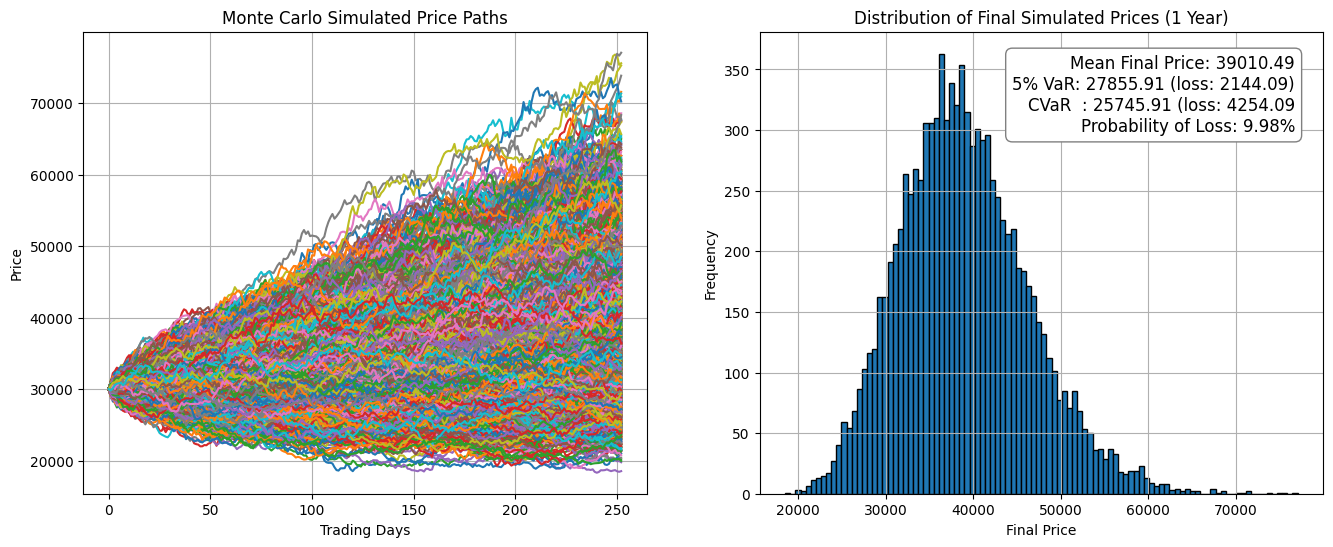

In [314]:
# Ploting graphs

fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Plot sample price paths in the first subplot
for i in range(M):
    axs[0].plot(price_paths[i])
axs[0].set_title("Monte Carlo Simulated Price Paths")
axs[0].set_xlabel("Trading Days")
axs[0].set_ylabel("Price")
axs[0].grid(True)


# Plot histogram of final prices in the second subplot
axs[1].hist(final_prices, bins=100, edgecolor='black')
axs[1].set_title("Distribution of Final Simulated Prices (1 Year)")
axs[1].set_xlabel("Final Price")
axs[1].set_ylabel("Frequency")
axs[1].grid(True)


mean_price = np.mean(final_prices)
var_5 = np.percentile(final_prices, 5)
prob_loss = np.mean(final_prices < S0)
cvar =  [i for i in list(final_prices) if i <= var_5]
cvar_5 = np.mean(cvar)

# Add text box with metrics
risk_text = (
    f"Mean Final Price: {mean_price:.2f}\n"
    f"5% VaR: {var_5:.2f} (loss: {S0-var_5:.2f})\n"
    f"CVaR  : {cvar_5:.2f} (loss: {S0 - cvar_5:.2f}\n"
    f"Probability of Loss: {prob_loss:.2%}"
)

# Place box in upper right
axs[1].text(
    0.95, 0.95, risk_text,
    transform=plt.gca().transAxes,
    fontsize=12,
    verticalalignment='top',
    horizontalalignment='right',
    bbox=dict(boxstyle="round,pad=0.4", facecolor='white', edgecolor='gray')
)

# Adjust layout and show both plots together
plt.show()

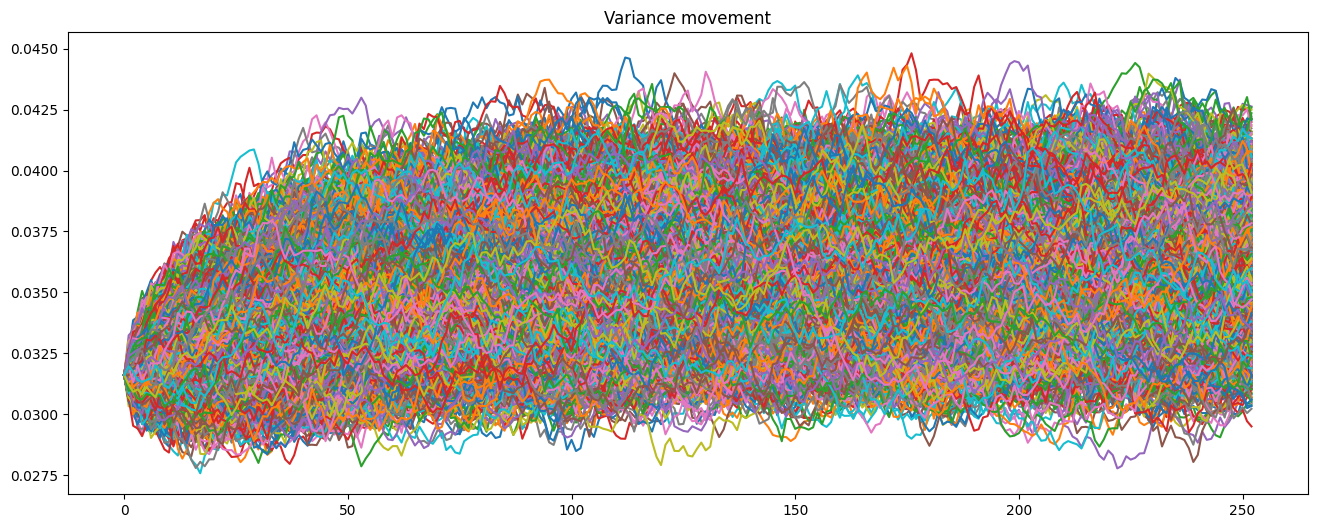

In [315]:
fig, axs = plt.subplots(figsize = (16,6))
for i in range(M):
  axs.plot(var_paths[i])
axs.plot(0,theta, 'r--')
axs.set_title("Variance movement")
plt.show()

In [316]:
min(final_prices)

np.float64(18516.59855435987)

In [317]:
S0 - min(final_prices)

np.float64(11483.401445640131)

In [318]:
max(final_prices) - S0

np.float64(47054.2769068365)